In [23]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Statistical modeling and diagnostics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import jarque_bera

# Machine learning and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("All libraries imported successfully")

All libraries imported successfully


In [24]:
manager_df = pd.read_excel('PM.xlsx')
ff3_df = pd.read_csv('F-F_Research_Data_Factors.csv')
ff3_df['Date'] = pd.to_datetime(ff3_df['Date'], format='%Y%m')
manager_df['Date'] = pd.to_datetime(manager_df['Date'], format='%Y%m')

ff3_df = ff3_df.set_index('Date')
manager_df = manager_df.set_index('Date')
manager_df /= 100
ff3_df /= 100

df = pd.merge(left=manager_df, right=ff3_df, left_index=True, right_index=True)


In [25]:
df

,PM1,PM2,Mkt-RF,SMB,HML,RF
Date,,,,,,
2005-01-01,-0.076055,0.001958,-0.0275,-0.0166,0.0206,0.0016
2005-02-01,0.009337,0.016970,0.0188,-0.0057,0.0141,0.0016
2005-03-01,-0.054809,-0.011818,-0.0194,-0.0141,0.0207,0.0021
2005-04-01,-0.070286,-0.006834,-0.0261,-0.0393,0.0005,0.0021
2005-05-01,0.084066,0.034652,0.0365,0.0286,-0.0058,0.0024
...,...,...,...,...,...,...
2024-08-01,0.003367,0.027668,0.0160,-0.0349,-0.0110,0.0048
2024-09-01,0.050677,0.003119,0.0172,-0.0013,-0.0277,0.0040
2024-10-01,-0.019468,-0.002286,-0.0100,-0.0099,0.0086,0.0039


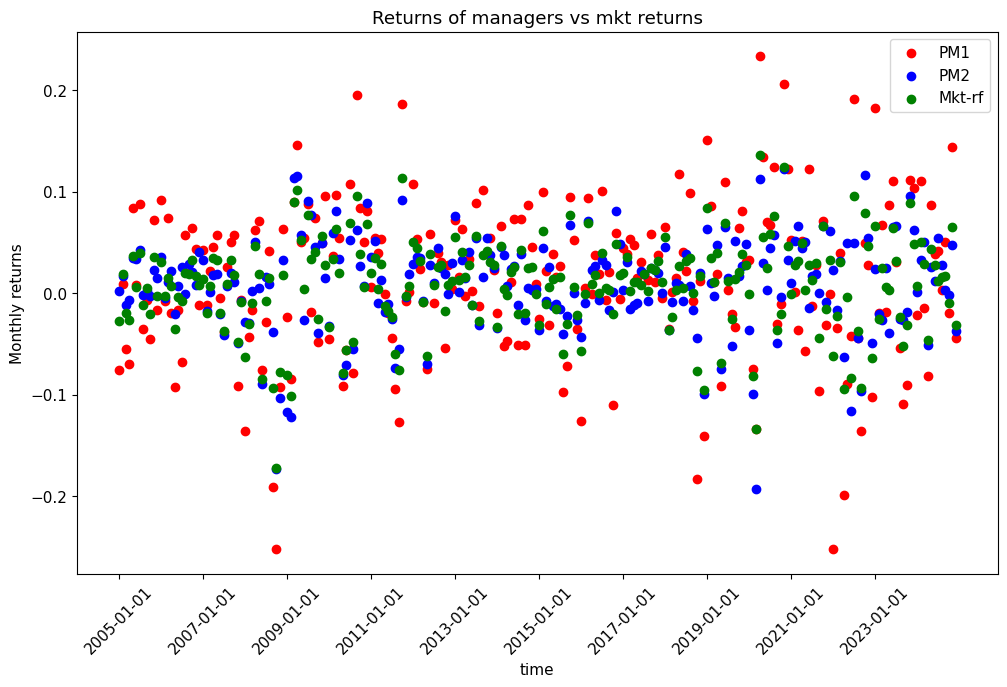

In [33]:
plt.scatter(y=df['PM1'], x=df.index,color='r', label='PM1')
plt.scatter(y=df['PM2'], x=df.index, color='b', label='PM2')
plt.scatter(y=df['Mkt-RF'], x=df.index, color='g', label='Mkt-rf')
plt.tight_layout()
plt.title('Returns of managers vs mkt returns')
plt.xlabel('time')
plt.ylabel('Monthly returns')
plt.xticks(ticks=df.index[::24], rotation=45)
plt.legend()
plt.show()






/var/folders/cf/zk37hd_50bv_nlrdlxrb4q3r0000gn/T/ipykernel_87416/3874894647.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df['PM1'], df['PM2']], labels=['PM1', 'PM2'])


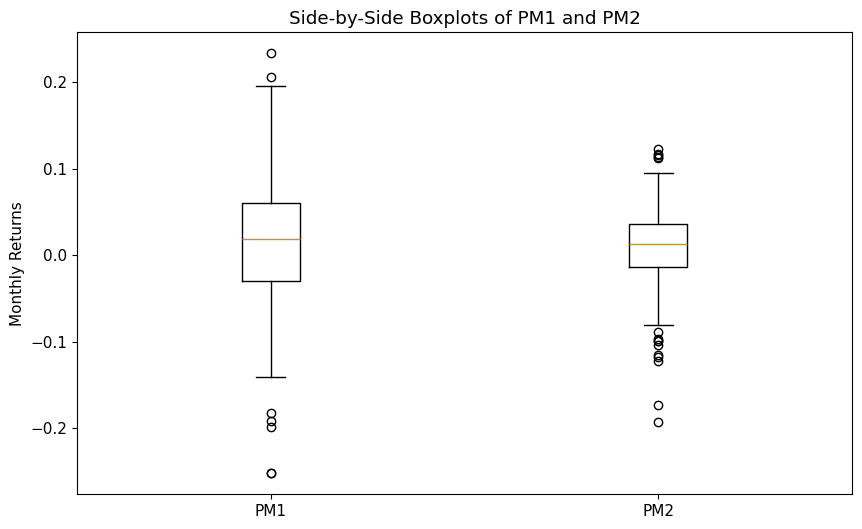

In [37]:
plt.figure(figsize=(10, 6))
plt.boxplot([df['PM1'], df['PM2']], labels=['PM1', 'PM2'])
plt.title('Side-by-Side Boxplots of PM1 and PM2')
plt.ylabel('Monthly Returns')
plt.show()

Differences between PM1 and PM2: 
1) Pm1 has much higher variance of returns than PM2. Both seem to have similar mean returns. PM2 also has many more outliers that PM1 particuarly in the negative direction.

There are several outliers for both series of plots for PM1 and PM2. PM2 has more outliers. 

In terms of outliers we may want to windzorise the data to remove high outliers and low ones too. 

In [39]:
df['PM1-RF'] = df['PM1']-df['RF']
df['PM2-RF'] = df['PM2']-df['RF']

df['PM1-MKT'] = df['PM1']-df['Mkt-RF']+df['RF']
df['PM2-MKT'] = df['PM2']-df['Mkt-RF']+df['RF']


In [44]:
def metrics(col):
    mu, sig = df[col].mean(), df[col].std()
    mu_xr = df[col+'-RF'].mean()
    var_xr = df[col+'-RF'].std() 

    SR = mu_xr/var_xr

    mu_xrm = df[col+'-MKT'].mean()
    var_xrm = df[col+'-MKT'].std()

    IR = mu_xrm/var_xrm
    
    returns = df[col].to_list()

    prod_returns = []
    cr = 1
    for i, r in enumerate(returns):
        cr*=(1+r)
        prod_returns.append(cr)


    n = len(returns)
    min_frm_rht = [prod_returns[n-1] for _ in range(n)]

    for i in range(1, n):
        min_frm_rht[n-1-i] = min(prod_returns[n-1-i],min_frm_rht[n-i])
    
    mx_drawdown = float('inf')

    for j, pr in enumerate(prod_returns):
        ddn = (min_frm_rht[j]-prod_returns[j])/prod_returns[j]
        mx_drawdown = min(ddn, mx_drawdown)

    mx_drawdown = 100*mx_drawdown

    print(f"STATS FOR {col}")
    print(f"Mean={mu:.4f} Std dev={sig:.4f}") 
    print(f"SR={SR:.4f} IR={IR:.4f}") 
    print(f"max drawdown={mx_drawdown:.4f} %") 
    print("X"*50)


metrics('PM1')
metrics('PM2')








STATS FOR PM1
Mean=0.0137 Std dev=0.0758
SR=0.1642 IR=0.1698
max drawdown=-59.2334 %
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
STATS FOR PM2
Mean=0.0087 Std dev=0.0466
SR=0.1584 IR=0.0958
max drawdown=-51.1975 %
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


In [42]:
#PM1 regression

Y = df['PM1-RF']
X = sm.add_constant(df[['Mkt-RF','HML','SMB']])

model_pm1 = sm.OLS(endog=Y, exog=X).fit()

model_pm1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 PM1-RF   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 1.361e+04
Date:                Sat, 11 Oct 2025   Prob (F-statistic):          4.96e-264
Time:                        15:35:36   Log-Likelihood:                 898.10
No. Observations:                 240   AIC:                            -1788.
Df Residuals:                     236   BIC:                            -1774.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.249      0.213      -0.000       0.001
Mkt-RF         1.4137      0.009    157.805      0.000       1.396       1.431
HML           -0.8074      0.012    -68.223      0.000      -0.831      -0.784
SMB            0.9894      0.016     62.211      0.000       0.958       1.021
==============================================================================
Omnibus:                        5.807   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                5.486
Skew:                           0.335   Prob(JB):                       0.0644
Kurtosis:                       3.317   Cond. No.                         43.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
#PM2 regression

Y = df['PM2-RF']
X = sm.add_constant(df[['Mkt-RF','HML','SMB']])

model_pm2 = sm.OLS(endog=Y, exog=X).fit()

model_pm2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 PM2-RF   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     2665.
Date:                Sat, 11 Oct 2025   Prob (F-statistic):          1.16e-181
Time:                        15:35:47   Log-Likelihood:                 821.48
No. Observations:                 240   AIC:                            -1635.
Df Residuals:                     236   BIC:                            -1621.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      1.135      0.257      -0.000       0.002
Mkt-RF         0.9076      0.012     73.620      0.000       0.883       0.932
HML            0.5677      0.016     34.858      0.000       0.536       0.600
SMB           -0.1012      0.022     -4.623      0.000      -0.144      -0.058
==============================================================================
Omnibus:                        5.462   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.065   Jarque-Bera (JB):                4.106
Skew:                           0.198   Prob(JB):                        0.128
Kurtosis:                       2.496   Cond. No.                         43.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

1. Who's better at beating the market? Definitely PM1 higher information ratio. 
2. Who generates a better sharpe ratio? Definiely PM1 by a little. 
3. THe higher FF3 information ratio is also from PM1, which has a higher t-stat for the coeffecient 1.249 vs PM2's 1.135. 